# A quantitative financial analysis of the Silver (USD) price

The following code uses a Kalman estimate on the 10y historical data of the SI=F
https://finance.yahoo.com/quote/SI%3DF/ 

Source of the data: Yahoo Finance
Purpose of the analysis: price predictions using ML (experiments)
Asset class: Silver (this is more or less independent of the asset class)

Explanation of the approach (brief):

Kalman estimates: can be used for time-series models if the data is noisy.
The estimates are based on the same unit (in this case USD).

Lorentzian indicator: used to incorporate volatility into this prediction.
The indicator can help to explain occurrences of minima and maxima.

Generally:
This isn't optimized, kept simple etc.
You could use logarithmic ranges etc. pp. 

Disclaimer:
This isn't financial advice. 

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

# Fetch Silver Futures data
si = yf.Ticker("SI=F")
df = si.history(period="10y")

# Remove any rows with NaN values and get the latest complete day
df = df.dropna()
latest_complete_day = df.index[-1]

# Ensure we're only working with complete data up to the latest complete day
df = df[:latest_complete_day]

# Initialize Kalman Filter
kf = KalmanFilter(
    initial_state_mean=df['Close'].iloc[0],
    initial_state_covariance=1,
    transition_matrices=[1],
    observation_matrices=[1],
    observation_covariance=1,
    transition_covariance=0.01
)

# Apply Kalman Filter
state_means, state_covariances = kf.filter(df['Close'])

# Add Kalman Filter estimates to the dataframe
df['KalmanEstimate'] = state_means

# Get the next day estimate
last_mean = state_means[-1]
last_covariance = state_covariances[-1]
next_mean, next_covariance = kf.filter_update(
    filtered_state_mean=last_mean,
    filtered_state_covariance=last_covariance
)

# Add the next day estimate to the dataframe
next_day = latest_complete_day + timedelta(days=1)
df.loc[next_day, 'KalmanEstimate'] = next_mean[0]

# Calculate last month's max and min
last_month_start = latest_complete_day - timedelta(days=30)
last_month = df.loc[last_month_start:]
last_month_max = last_month['High'].max()
last_month_min = last_month['Low'].min()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Closing Price')
plt.plot(df.index, df['KalmanEstimate'], label='Kalman Filter Estimate', color='red')
plt.scatter(next_day, next_mean, color='green', s=100, label='Next Day Estimate')

# Add horizontal lines for last month's max and min
plt.axhline(y=last_month_max, color='orange', linestyle='--', label='Last Month Max')
plt.axhline(y=last_month_min, color='purple', linestyle='--', label='Last Month Min')

plt.title('Silver Futures Price with Kalman Filter Estimate and Additional Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Print the last few days of data and the next day estimate
print("Last 5 days of complete data:")
print(df[['Close', 'KalmanEstimate']].tail())

print(f"\nLast complete day in dataset:")
print(df[['Open', 'High', 'Low', 'Close']].iloc[-2])

print(f"\nNext day estimate: {next_mean[0]:.2f}")
print(f"Estimate uncertainty: {np.sqrt(next_covariance[0][0]):.2f}")

print(f"\nLast month's maximum price: {last_month_max:.2f}")
print(f"\nLast month's minimum price: {last_month_min:.2f}")

# Print the date range of the data
print(f"\nData range: from {df.index[0].date()} to {df.index[-1].date()}")

print(f"\nCurrent date and time: {datetime.now()}")

In [11]:
print(df)

                                Open       High        Low      Close  \
Date                                                                    
2022-08-24 00:00:00-04:00  18.834999  19.040001  18.820000  18.895000   
2022-08-25 00:00:00-04:00  19.045000  19.111000  19.035000  19.111000   
2022-08-26 00:00:00-04:00  19.305000  19.305000  18.740000  18.740000   
2022-08-29 00:00:00-04:00  18.520000  18.555000  18.520000  18.555000   
2022-08-30 00:00:00-04:00  18.565001  18.584999  18.120001  18.159000   
...                              ...        ...        ...        ...   
2024-08-20 00:00:00-04:00  29.855000  29.955000  29.455000  29.455000   
2024-08-21 00:00:00-04:00  29.476000  29.476000  29.476000  29.476000   
2024-08-22 00:00:00-04:00  29.445000  29.450001  29.000000  29.006001   
2024-08-23 00:00:00-04:00  29.785999  29.785999  29.785999  29.785999   
2024-08-24 00:00:00-04:00        NaN        NaN        NaN        NaN   

                            Volume  Dividends  Sto

## Adding more indicators for visual exploration

I am adding the RSI (Relative Strength Index)

One interpretation of this:

RSI > 70: Generally considered overbought
RSI < 30: Generally considered oversold
RSI = 50: Neutral
50-70: Bullish
30-50: Bearish

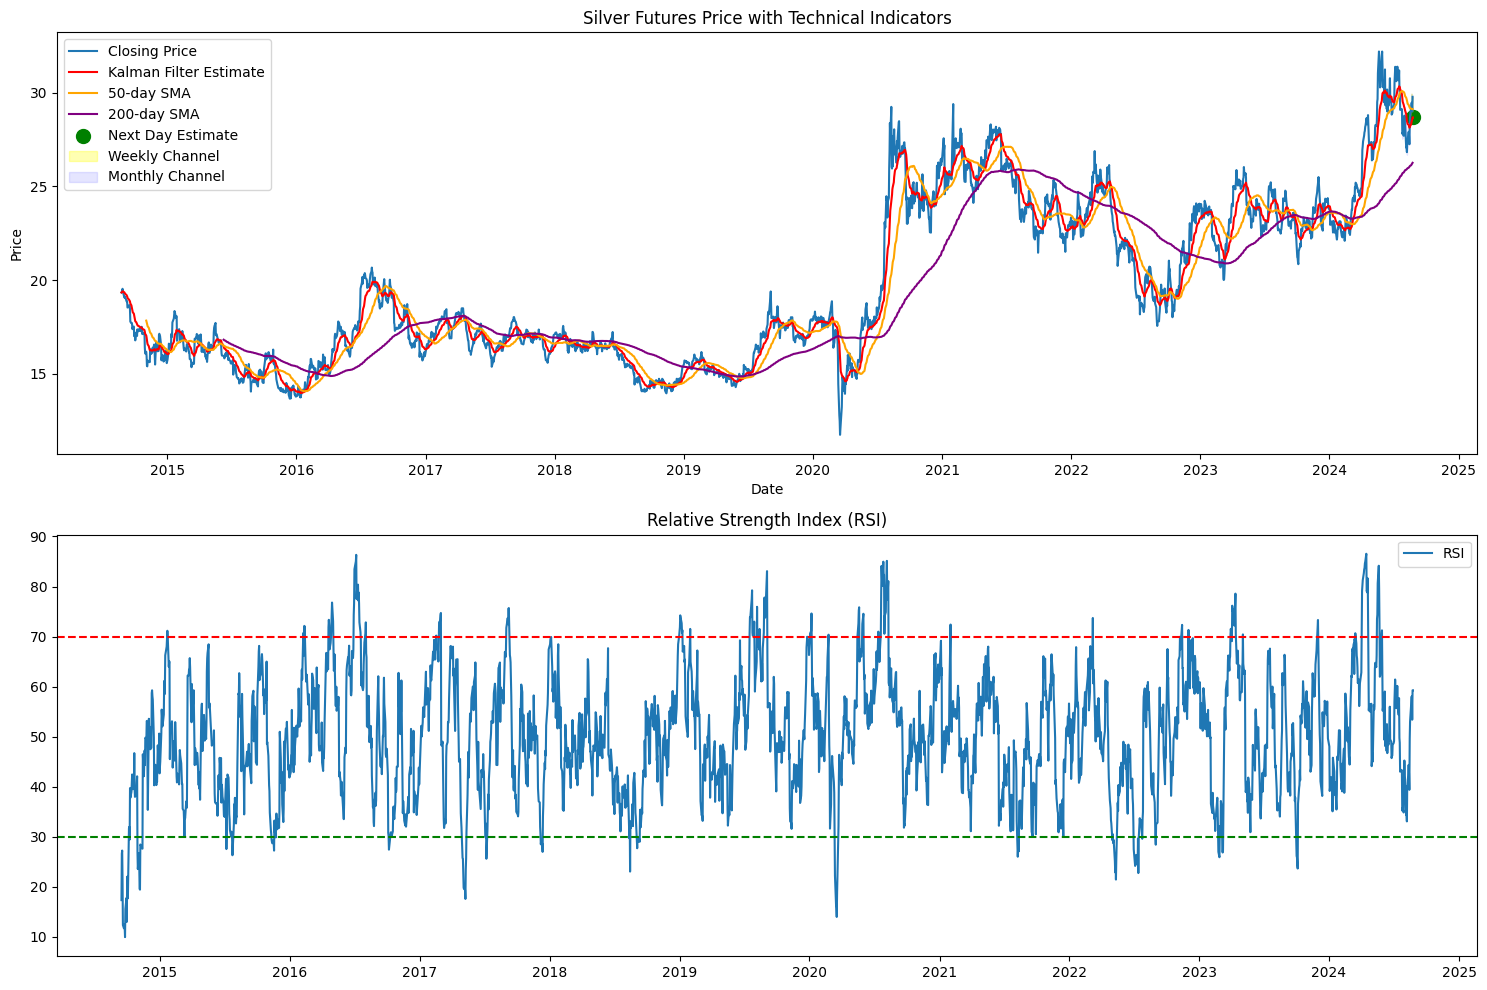

Last 5 days of complete data:
                               Close  KalmanEstimate     RSI_14
Date                                                           
2024-08-20 00:00:00-04:00  29.455000       28.424126  57.924752
2024-08-21 00:00:00-04:00  29.476000       28.524186  58.078138
2024-08-22 00:00:00-04:00  29.006001       28.570018  53.387184
2024-08-23 00:00:00-04:00  29.785999       28.685688  59.267148
2024-08-24 00:00:00-04:00        NaN       28.685688  59.267148

Last complete day in dataset:
Open     29.785999
High     29.785999
Low      29.785999
Close    29.785999
Name: 2024-08-23 00:00:00-04:00, dtype: float64

Next day estimate: 28.69
Estimate uncertainty: 0.32

Last month's trading range: 26.69 - 29.95
Last week's trading range: 28.78 - 29.95

Data range: from 2014-08-25 to 2024-08-24

Current date and time: 2024-08-24 06:58:02.497803


In [15]:
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

# Fetch Silver Futures data
si = yf.Ticker("SI=F")
df = si.history(period="10y")

# Remove any rows with NaN values and get the latest complete day
df = df.dropna()
latest_complete_day = df.index[-1]

# Ensure we're only working with complete data up to the latest complete day
df = df[:latest_complete_day]

# Initialize Kalman Filter
kf = KalmanFilter(
    initial_state_mean=df['Close'].iloc[0],
    initial_state_covariance=1,
    transition_matrices=[1],
    observation_matrices=[1],
    observation_covariance=1,
    transition_covariance=0.01
)

# Apply Kalman Filter
state_means, state_covariances = kf.filter(df['Close'])

# Add Kalman Filter estimates to the dataframe
df['KalmanEstimate'] = state_means

# Get the next day estimate
last_mean = state_means[-1]
last_covariance = state_covariances[-1]
next_mean, next_covariance = kf.filter_update(
    filtered_state_mean=last_mean,
    filtered_state_covariance=last_covariance
)

# Add the next day estimate to the dataframe
next_day = latest_complete_day + timedelta(days=1)
df.loc[next_day, 'KalmanEstimate'] = next_mean[0]

# Calculate last month's and last week's max and min
last_month_start = latest_complete_day - timedelta(days=30)
last_week_start = latest_complete_day - timedelta(days=7)
last_month = df.loc[last_month_start:]
last_week = df.loc[last_week_start:]

# Add technical indicators
df.ta.rsi(close='Close', length=14, append=True)
df.ta.macd(close='Close', fast=12, slow=26, signal=9, append=True)
df['SMA_50'] = ta.sma(df['Close'], length=50)
df['SMA_200'] = ta.sma(df['Close'], length=200)

# Plot the results
plt.figure(figsize=(15, 10))

# Main price chart
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Close'], label='Closing Price')
plt.plot(df.index, df['KalmanEstimate'], label='Kalman Filter Estimate', color='red')
plt.plot(df.index, df['SMA_50'], label='50-day SMA', color='orange')
plt.plot(df.index, df['SMA_200'], label='200-day SMA', color='purple')
plt.scatter(next_day, next_mean, color='green', s=100, label='Next Day Estimate')

# Add trend channels
plt.fill_between(last_week.index, last_week['High'], last_week['Low'], color='yellow', alpha=0.3, label='Weekly Channel')
plt.fill_between(last_month.index, last_month['High'], last_month['Low'], color='blue', alpha=0.1, label='Monthly Channel')

plt.title('Silver Futures Price with Technical Indicators')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# RSI subplot
plt.subplot(2, 1, 2)
plt.plot(df.index, df['RSI_14'], label='RSI')
plt.axhline(y=70, color='red', linestyle='--')
plt.axhline(y=30, color='green', linestyle='--')
plt.title('Relative Strength Index (RSI)')
plt.legend()

plt.tight_layout()
plt.show()

# Print the last few days of data and the next day estimate
print("Last 5 days of complete data:")
print(df[['Close', 'KalmanEstimate', 'RSI_14']].tail())
print(f"\nLast complete day in dataset:")
print(df[['Open', 'High', 'Low', 'Close']].iloc[-2])
print(f"\nNext day estimate: {next_mean[0]:.2f}")
print(f"Estimate uncertainty: {np.sqrt(next_covariance[0][0]):.2f}")
print(f"\nLast month's trading range: {last_month['Low'].min():.2f} - {last_month['High'].max():.2f}")
print(f"Last week's trading range: {last_week['Low'].min():.2f} - {last_week['High'].max():.2f}")
print(f"\nData range: from {df.index[0].date()} to {df.index[-1].date()}")
print(f"\nCurrent date and time: {datetime.now()}")

## Using Plotly instead for better zooming

Plotly can also be used as part of Dash. This is great for custom finance dashboards.

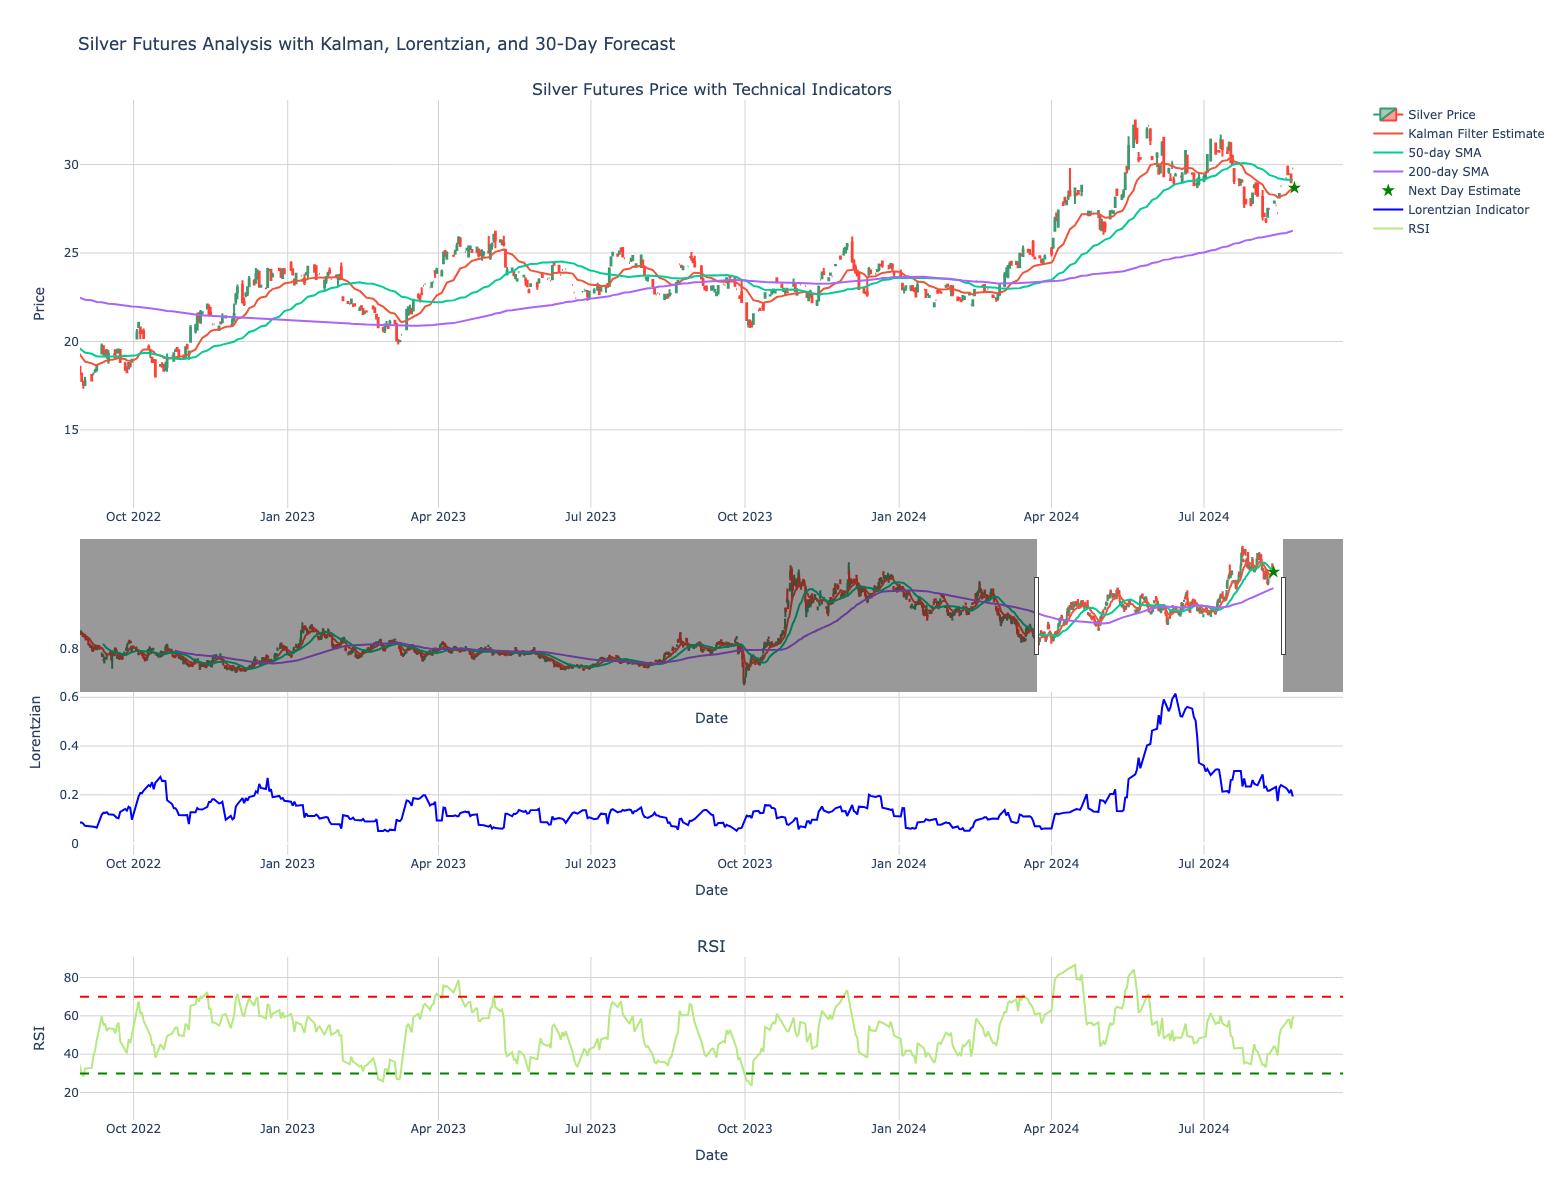

Last 5 days of complete data:
                               Close  KalmanEstimate  Lorentzian     RSI_14
Date                                                                       
2024-08-20 00:00:00-04:00  29.455000       28.424126    0.220052  57.924752
2024-08-21 00:00:00-04:00  29.476000       28.524186    0.207072  58.078138
2024-08-22 00:00:00-04:00  29.006001       28.570018    0.220814  53.387184
2024-08-23 00:00:00-04:00  29.785999       28.685688    0.193158  59.267148
2024-08-24 00:00:00-04:00        NaN       28.685688         NaN  59.267148

Last complete day in dataset:
Open     29.785999
High     29.785999
Low      29.785999
Close    29.785999
Name: 2024-08-23 00:00:00-04:00, dtype: float64

Next day estimate: 28.69
Estimate uncertainty: 0.32

Data range: from 2014-08-25 to 2024-08-24

Current date and time: 2024-08-24 11:31:32.989848

30-Day Forecast:
Estimated price after 30 days: $28.69
Forecast uncertainty: 0.62


In [26]:
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from pykalman import KalmanFilter
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import timedelta, datetime

# Fetch Silver Futures data
si = yf.Ticker("SI=F")
df = si.history(period="10y")

# Remove any rows with NaN values and get the latest complete day
df = df.dropna()
latest_complete_day = df.index[-1]

# Ensure we're only working with complete data up to the latest complete day
df = df[:latest_complete_day]

# Initialize Kalman Filter
kf = KalmanFilter(
    initial_state_mean=df['Close'].iloc[0],
    initial_state_covariance=1,
    transition_matrices=[1],
    observation_matrices=[1],
    observation_covariance=1,
    transition_covariance=0.01
)

# Apply Kalman Filter
state_means, state_covariances = kf.filter(df['Close'])

# Add Kalman Filter estimates to the dataframe
df['KalmanEstimate'] = state_means

# Get the next day estimate
last_mean = state_means[-1]
last_covariance = state_covariances[-1]
next_mean, next_covariance = kf.filter_update(
    filtered_state_mean=last_mean,
    filtered_state_covariance=last_covariance
)

# Add the next day estimate to the dataframe
next_day = latest_complete_day + timedelta(days=1)
df.loc[next_day, 'KalmanEstimate'] = next_mean[0]

# Add technical indicators using pandas-ta
df.ta.rsi(close='Close', length=14, append=True)
df.ta.sma(close='Close', length=50, append=True)
df.ta.sma(close='Close', length=200, append=True)

# Implement Lorentzian indicator
def lorentzian_indicator(data, period=14):
    delta = data.diff()
    sq_delta = delta**2
    lorentzian = np.log(1 + sq_delta)
    return lorentzian.rolling(window=period).mean()

df['Lorentzian'] = lorentzian_indicator(df['Close'])

# Function to forecast using Kalman Filter
def kalman_forecast(last_mean, last_covariance, days):
    forecasted_means = [last_mean]
    forecasted_covariances = [last_covariance]
    
    for _ in range(days - 1):
        next_mean, next_covariance = kf.filter_update(
            filtered_state_mean=forecasted_means[-1],
            filtered_state_covariance=forecasted_covariances[-1]
        )
        forecasted_means.append(next_mean[0])
        forecasted_covariances.append(next_covariance[0][0])
    
    return forecasted_means, forecasted_covariances

# Make 30-day forecast
forecast_days = 30
forecasted_means, forecasted_covariances = kalman_forecast(last_mean, last_covariance, forecast_days)

# Create date range for forecast
forecast_dates = pd.date_range(start=next_day, periods=forecast_days)

# Create subplots with adjusted row heights
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, 
                    vertical_spacing=0.1, 
                    subplot_titles=('Silver Futures Price with Technical Indicators', 'Lorentzian Indicator', 'RSI'),
                    row_heights=[0.5, 0.3, 0.2])

# Add candlestick chart
fig.add_trace(go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Silver Price'),
                row=1, col=1)

# Add other traces to main price chart
fig.add_trace(go.Scatter(x=df.index, y=df['KalmanEstimate'], name='Kalman Filter Estimate'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['SMA_50'], name='50-day SMA'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['SMA_200'], name='200-day SMA'), row=1, col=1)
fig.add_trace(go.Scatter(x=[next_day], y=[next_mean[0]], mode='markers', name='Next Day Estimate', 
                         marker=dict(size=10, color='green', symbol='star')), row=1, col=1)

# Add 30-day forecast
fig.add_trace(go.Scatter(x=forecast_dates, y=forecasted_means, 
                         mode='lines', name='30-Day Forecast', 
                         line=dict(color='purple', dash='dash')), row=1, col=1)

# Add Lorentzian indicator to its own subplot
fig.add_trace(go.Scatter(x=df.index, y=df['Lorentzian'], name='Lorentzian Indicator', line=dict(color='blue')), row=2, col=1)

# Add RSI to subplot
fig.add_trace(go.Scatter(x=df.index, y=df['RSI_14'], name='RSI'), row=3, col=1)
fig.add_hline(y=70, line_dash="dash", line_color="red", row=3, col=1)
fig.add_hline(y=30, line_dash="dash", line_color="green", row=3, col=1)

# Update layout
fig.update_layout(height=1200, width=1200, title_text="Silver Futures Analysis with Kalman, Lorentzian, and 30-Day Forecast")

# Update x-axes to show time for all subplots and extend range for forecast
fig.update_xaxes(title_text="Date", row=1, col=1, showticklabels=True, range=[df.index[-500], forecast_dates[-1]])
fig.update_xaxes(title_text="Date", row=2, col=1, showticklabels=True, range=[df.index[-500], forecast_dates[-1]])
fig.update_xaxes(title_text="Date", row=3, col=1, showticklabels=True, range=[df.index[-500], forecast_dates[-1]])

fig.update_yaxes(title_text="Price", row=1, col=1)
fig.update_yaxes(title_text="Lorentzian", row=2, col=1)
fig.update_yaxes(title_text="RSI", row=3, col=1)

# Update the layout to have a white background
fig.update_layout(plot_bgcolor='white', paper_bgcolor='white')

# Add gridlines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')

# Show the plot
fig.show()

# Print additional information
print("Last 5 days of complete data:")
print(df[['Close', 'KalmanEstimate', 'Lorentzian', 'RSI_14']].tail())
print(f"\nLast complete day in dataset:")
print(df[['Open', 'High', 'Low', 'Close']].iloc[-2])
print(f"\nNext day estimate: {next_mean[0]:.2f}")
print(f"Estimate uncertainty: {np.sqrt(next_covariance[0][0]):.2f}")
print(f"\nData range: from {df.index[0].date()} to {df.index[-1].date()}")
print(f"\nCurrent date and time: {datetime.now()}")

# Print 30-day forecast
print("\n30-Day Forecast:")
print(f"Estimated price after 30 days: ${forecasted_means[-1]:.2f}")
print(f"Forecast uncertainty: {np.sqrt(forecasted_covariances[-1]):.2f}")

## Building a Machine Learning model to predict the price

Couple of notes here:

1.) This isn't made to guide any investors (!) 

2.) Silver may not be a viable asset class even

3.) Yahoo Finance is free. You can use other sources. This matters A LOT (!) as you will see. We don't get all the history data.

In [27]:
import yfinance as yf
import pandas as pd
import numpy as np
from pykalman import KalmanFilter
import pandas_ta as ta
from datetime import datetime

# Fetch Silver Futures data from 1980 to today
si = yf.Ticker("SI=F")
df = si.history(start="1980-01-01", end=datetime.today().strftime('%Y-%m-%d'))

# Remove any rows with NaN values
df = df.dropna()

# Calculate RSI
df['RSI_14'] = ta.rsi(df['Close'], length=14)

# Implement Lorentzian indicator
def lorentzian_indicator(data, period=14):
    delta = data.diff()
    sq_delta = delta**2
    lorentzian = np.log(1 + sq_delta)
    return lorentzian.rolling(window=period).mean()

df['Lorentzian'] = lorentzian_indicator(df['Close'])

# Initialize and apply Kalman Filter
kf = KalmanFilter(
    initial_state_mean=df['Close'].iloc[0],
    initial_state_covariance=1,
    transition_matrices=[1],
    observation_matrices=[1],
    observation_covariance=1,
    transition_covariance=0.01
)

state_means, _ = kf.filter(df['Close'])
df['KalmanEstimate'] = state_means

# Select only the columns we need
ml_df = df[['Open', 'High', 'Low', 'Close', 'Lorentzian', 'KalmanEstimate', 'RSI_14']]

# Remove any remaining NaN values (first few rows might have NaNs due to indicator calculations)
ml_df = ml_df.dropna()

# Display the first few rows of the dataframe
print(ml_df.head())

# Display basic information about the dataframe
print(ml_df.info())

# Save to CSV (optional)
# ml_df.to_csv('silver_data_for_ml.csv')

# The DataFrame 'ml_df' is now ready for use in machine learning applications

                           Open   High   Low  Close  Lorentzian  \
Date                                                              
2000-09-20 00:00:00-04:00  4.86  4.865  4.83  4.830    0.000976   
2000-09-21 00:00:00-04:00  4.90  4.900  4.87  4.872    0.000722   
2000-09-22 00:00:00-04:00  4.90  4.910  4.90  4.910    0.000825   
2000-09-25 00:00:00-04:00  4.90  4.915  4.86  4.915    0.000824   
2000-09-26 00:00:00-04:00  4.93  4.931  4.93  4.931    0.000827   

                           KalmanEstimate     RSI_14  
Date                                                  
2000-09-20 00:00:00-04:00        4.908093  27.901917  
2000-09-21 00:00:00-04:00        4.904411  40.962000  
2000-09-22 00:00:00-04:00        4.904974  49.818768  
2000-09-25 00:00:00-04:00        4.905973  50.863331  
2000-09-26 00:00:00-04:00        4.908448  54.152181  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6005 entries, 2000-09-20 00:00:00-04:00 to 2024-08-23 00:00:00-04:00
Data columns (total 7 c

In [28]:
ml_df.head(3)

Open   High   Low  Close  Lorentzian  \
Date                                                              
2000-09-20 00:00:00-04:00  4.86  4.865  4.83  4.830    0.000976   
2000-09-21 00:00:00-04:00  4.90  4.900  4.87  4.872    0.000722   
2000-09-22 00:00:00-04:00  4.90  4.910  4.90  4.910    0.000825   

                           KalmanEstimate     RSI_14  
Date                                                  
2000-09-20 00:00:00-04:00        4.908093  27.901917  
2000-09-21 00:00:00-04:00        4.904411  40.962000  
2000-09-22 00:00:00-04:00        4.904974  49.818768

In [29]:
ml_df.tail(3)

Open       High        Low      Close  \
Date                                                                    
2024-08-21 00:00:00-04:00  29.476000  29.476000  29.476000  29.476000   
2024-08-22 00:00:00-04:00  29.445000  29.450001  29.000000  29.006001   
2024-08-23 00:00:00-04:00  29.785999  29.785999  29.785999  29.785999   

                           Lorentzian  KalmanEstimate     RSI_14  
Date                                                              
2024-08-21 00:00:00-04:00    0.207072       28.524186  58.078138  
2024-08-22 00:00:00-04:00    0.220814       28.570018  53.387184  
2024-08-23 00:00:00-04:00    0.193158       28.685688  59.267148

## Using automated feature extraction with TPOT to build a linear regression model

This was not successful. I didn't expect it to be.

TPOT is a Genetic Programming based AutoML tool, which is formidable to build classifiers.
It hasn't got support for time series.

That being said, you can use TPOT for time series data and improve this approach.
I didn't do this here.

In [35]:
import pandas as pd
import numpy as np
from tsfresh import extract_features, select_features
from tsfresh.feature_extraction import MinimalFCParameters
from tsfresh.utilities.dataframe_functions import impute
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Assume 'ml_df' is your DataFrame with silver data

# Prepare data
data = ml_df[['Low', 'Open', 'High', 'Close', 'Lorentzian', 'KalmanEstimate', 'RSI_14']].copy()
data = data.reset_index(drop=True)

print(f"Original data shape: {data.shape}")

# Prepare data for tsfresh
data['id'] = 1  # Treat all rows as a single time series
data['time'] = range(len(data))  # Use row index as time

# Extract features using tsfresh with MinimalFCParameters
fc_parameters = MinimalFCParameters()
extracted_features = extract_features(data, column_id='id', column_sort='time',
                                      default_fc_parameters=fc_parameters, n_jobs=4)

print(f"Extracted features shape: {extracted_features.shape}")

# Impute any missing values in the extracted features
impute(extracted_features)

print(f"Imputed features shape: {extracted_features.shape}")

# Prepare target variable (Low price 30 days in the future)
y = data['Low'].shift(-30)

# Align features and target
X = pd.concat([extracted_features] * len(data), ignore_index=True)
X = X.iloc[:-30]
y = y[:-30]

print(f"X shape after alignment: {X.shape}")
print(f"y shape after alignment: {y.shape}")

# Remove any remaining NaN values
X = X.dropna(axis=1)
X, y = X.align(y, join='inner', axis=0)

print(f"Final X shape: {X.shape}")
print(f"Final y shape: {y.shape}")

if X.shape[0] == 0:
    print("No samples remaining after processing. Check your data and processing steps.")
else:
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Run TPOT
    tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42, n_jobs=-1)
    tpot.fit(X_train, y_train)

    # Make predictions
    y_pred = tpot.predict(X_test)

    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")

    # To make a prediction for one month from the last data point:
    future_prediction = tpot.predict(X.iloc[-1:])[0]
    print(f"Predicted low price one month from last data point: {future_prediction}")

    # The best model pipeline
    print(tpot.fitted_pipeline_)

    # Feature importance (if the best model supports it)
    if hasattr(tpot.fitted_pipeline_[-1], 'feature_importances_'):
        importances = tpot.fitted_pipeline_[-1].feature_importances_
        feature_importance = pd.DataFrame({'feature': X.columns, 'importance': importances})
        print(feature_importance.sort_values('importance', ascending=False).head(10))

Original data shape: (6005, 7)


Feature Extraction: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 383.62it/s]

Extracted features shape: (1, 70)
Imputed features shape: (1, 70)


X shape after alignment: (5975, 70)
y shape after alignment: (5975,)
Final X shape: (5975, 70)
Final y shape: (5975,)
                                                                                                                                                                                    
Generation 1 - Current best internal CV score: -68.08321130429651
                                                                                                                                                                                    
Generation 2 - Current best internal CV score: -68.08262617877634
                                                                                                                                                                                    
Generation 3 - Current best internal CV score: -68.07832065830371
                                                                                                                                             

This classifier doesn't perform well.

I wanted such an example in this Notebook to make a point:

How do you see bad performing ML models.

## Building a SI price prediction model with SARIMA, Kalman Estimates and Lorentzian indication

SARIMA is a model made for time series based forecasts. 

Data shape: (6005, 3)
                               SARIMAX Results                                
Dep. Variable:                    Low   No. Observations:                 4804
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1543.839
Date:                Sat, 24 Aug 2024   AIC                           3101.679
Time:                        13:07:21   BIC                           3147.018
Sample:                             0   HQIC                          3117.602
                               - 4804                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
KalmanEstimate     1.1079      0.008    136.714      0.000       1.092       1.124
Lorentzian        -4.3912      0.074    -59.264      0.000      -4.536      -4.246
ar.L1         

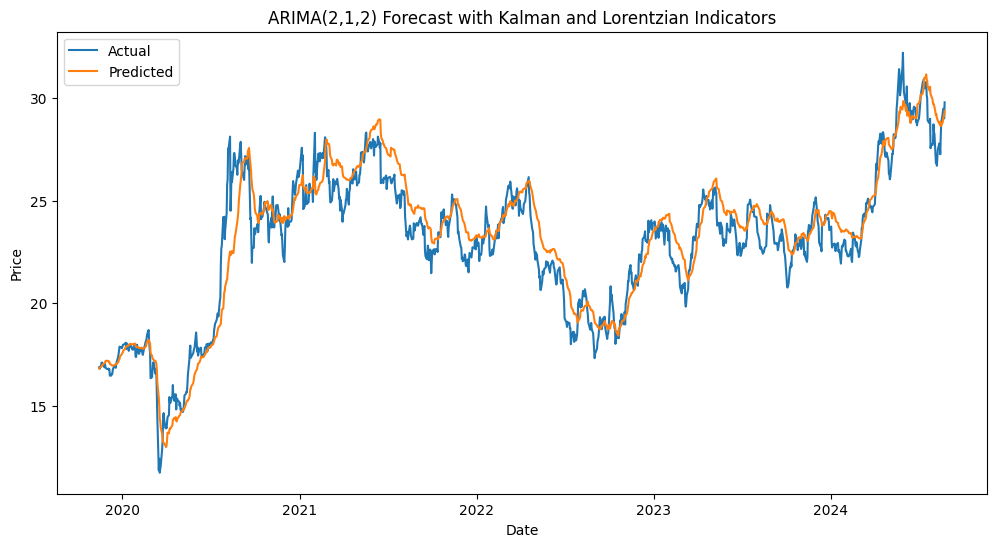


Predictions for the next 30 days:
2024-08-24: 28.77
2024-08-25: 28.84
2024-08-26: 28.91
2024-08-27: 28.97
2024-08-28: 29.02
2024-08-29: 29.07
2024-08-30: 29.11
2024-08-31: 29.14
2024-09-01: 29.17
2024-09-02: 29.20
2024-09-03: 29.22
2024-09-04: 29.24
2024-09-05: 29.26
2024-09-06: 29.27
2024-09-07: 29.28
2024-09-08: 29.30
2024-09-09: 29.31
2024-09-10: 29.31
2024-09-11: 29.32
2024-09-12: 29.33
2024-09-13: 29.33
2024-09-14: 29.34
2024-09-15: 29.34
2024-09-16: 29.35
2024-09-17: 29.35
2024-09-18: 29.35
2024-09-19: 29.36
2024-09-20: 29.36
2024-09-21: 29.36
2024-09-22: 29.36


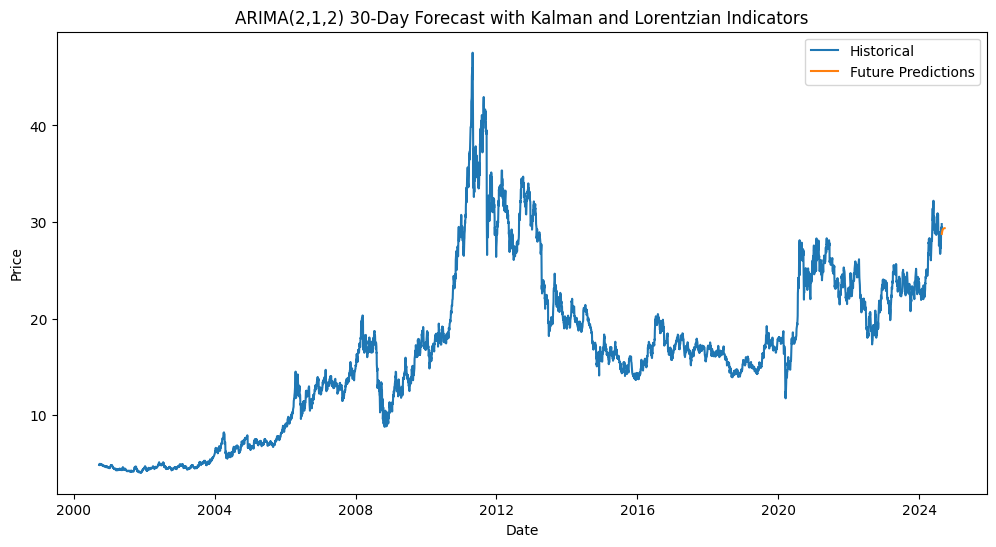

In [36]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Assume 'ml_df' is your DataFrame with silver data

# Prepare data
data = ml_df[['Low', 'KalmanEstimate', 'Lorentzian']].copy()
data = data.dropna()  # Remove any rows with NaN values

print(f"Data shape: {data.shape}")

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Fit the ARIMA model
model = ARIMA(train['Low'], exog=train[['KalmanEstimate', 'Lorentzian']], order=(2,1,2))
results = model.fit()

# Print model summary
print(results.summary())

# Make predictions
predictions = results.forecast(steps=len(test), exog=test[['KalmanEstimate', 'Lorentzian']])

# Calculate MSE and RMSE
mse = mean_squared_error(test['Low'], predictions)
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Low'], label='Actual')
plt.plot(test.index, predictions, label='Predicted')
plt.title('ARIMA(2,1,2) Forecast with Kalman and Lorentzian Indicators')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Predict the next 30 days
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30)
last_kalman = data['KalmanEstimate'].iloc[-1]
last_lorentzian = data['Lorentzian'].iloc[-1]

# Assuming Kalman and Lorentzian values stay the same for the next 30 days
future_exog = pd.DataFrame({'KalmanEstimate': [last_kalman] * 30, 
                            'Lorentzian': [last_lorentzian] * 30}, 
                           index=future_dates)

future_predictions = results.forecast(steps=30, exog=future_exog)

print("\nPredictions for the next 30 days:")
for date, price in zip(future_dates, future_predictions):
    print(f"{date.date()}: {price:.2f}")

# Plot future predictions
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Low'], label='Historical')
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.title('ARIMA(2,1,2) 30-Day Forecast with Kalman and Lorentzian Indicators')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Data shape: (6005, 3)
                               SARIMAX Results                                
Dep. Variable:                    Low   No. Observations:                 4804
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1543.839
Date:                Sat, 24 Aug 2024   AIC                           3101.679
Time:                        13:10:11   BIC                           3147.018
Sample:                             0   HQIC                          3117.602
                               - 4804                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
KalmanEstimate     1.1079      0.008    136.714      0.000       1.092       1.124
Lorentzian        -4.3912      0.074    -59.264      0.000      -4.536      -4.246
ar.L1         

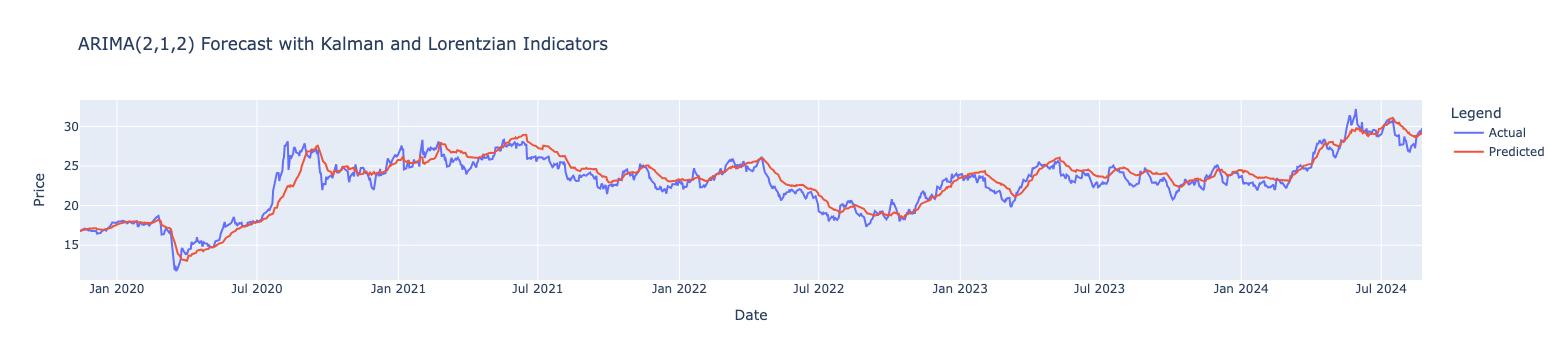


Predictions for the next 30 days:
2024-08-24: 28.77
2024-08-25: 28.84
2024-08-26: 28.91
2024-08-27: 28.97
2024-08-28: 29.02
2024-08-29: 29.07
2024-08-30: 29.11
2024-08-31: 29.14
2024-09-01: 29.17
2024-09-02: 29.20
2024-09-03: 29.22
2024-09-04: 29.24
2024-09-05: 29.26
2024-09-06: 29.27
2024-09-07: 29.28
2024-09-08: 29.30
2024-09-09: 29.31
2024-09-10: 29.31
2024-09-11: 29.32
2024-09-12: 29.33
2024-09-13: 29.33
2024-09-14: 29.34
2024-09-15: 29.34
2024-09-16: 29.35
2024-09-17: 29.35
2024-09-18: 29.35
2024-09-19: 29.36
2024-09-20: 29.36
2024-09-21: 29.36
2024-09-22: 29.36


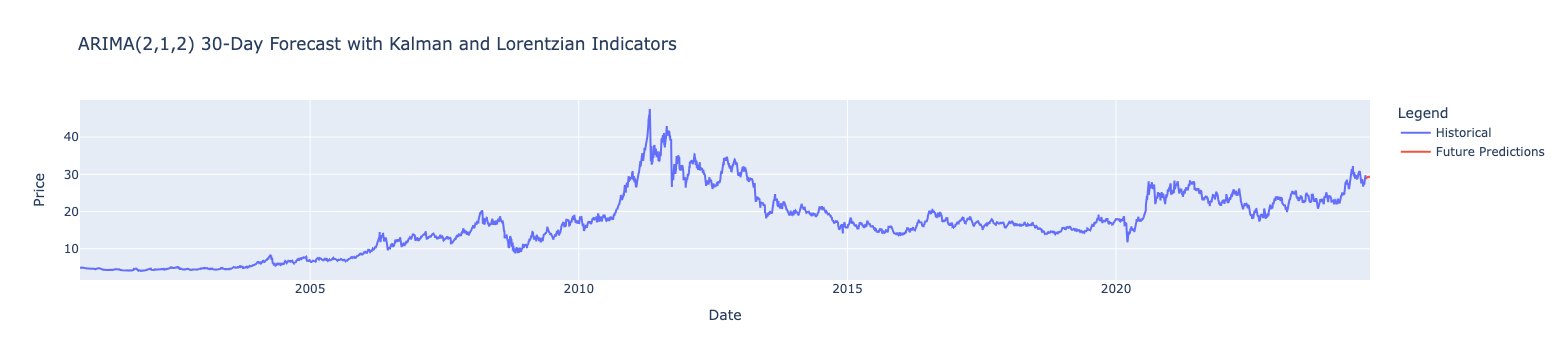

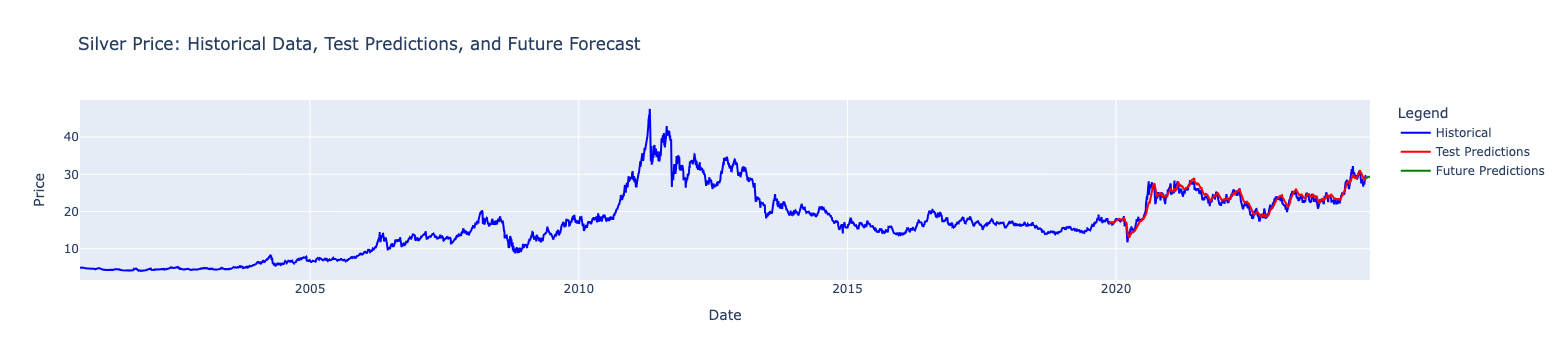

In [37]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assume 'ml_df' is your DataFrame with silver data

# Prepare data
data = ml_df[['Low', 'KalmanEstimate', 'Lorentzian']].copy()
data = data.dropna()  # Remove any rows with NaN values

print(f"Data shape: {data.shape}")

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Fit the ARIMA model
model = ARIMA(train['Low'], exog=train[['KalmanEstimate', 'Lorentzian']], order=(2,1,2))
results = model.fit()

# Print model summary
print(results.summary())

# Make predictions
predictions = results.forecast(steps=len(test), exog=test[['KalmanEstimate', 'Lorentzian']])

# Calculate MSE and RMSE
mse = mean_squared_error(test['Low'], predictions)
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

# Create a Plotly figure for test set predictions
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=test.index, y=test['Low'], mode='lines', name='Actual'))
fig1.add_trace(go.Scatter(x=test.index, y=predictions, mode='lines', name='Predicted'))
fig1.update_layout(
    title='ARIMA(2,1,2) Forecast with Kalman and Lorentzian Indicators',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend'
)

# Show the plot
fig1.show()

# Predict the next 30 days
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30)
last_kalman = data['KalmanEstimate'].iloc[-1]
last_lorentzian = data['Lorentzian'].iloc[-1]

# Assuming Kalman and Lorentzian values stay the same for the next 30 days
future_exog = pd.DataFrame({'KalmanEstimate': [last_kalman] * 30, 
                            'Lorentzian': [last_lorentzian] * 30}, 
                           index=future_dates)

future_predictions = results.forecast(steps=30, exog=future_exog)

print("\nPredictions for the next 30 days:")
for date, price in zip(future_dates, future_predictions):
    print(f"{date.date()}: {price:.2f}")

# Create a Plotly figure for future predictions
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=data.index, y=data['Low'], mode='lines', name='Historical'))
fig2.add_trace(go.Scatter(x=future_dates, y=future_predictions, mode='lines', name='Future Predictions'))
fig2.update_layout(
    title='ARIMA(2,1,2) 30-Day Forecast with Kalman and Lorentzian Indicators',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend'
)

# Show the plot
fig2.show()

# Create a subplot with all data, predictions, and forecasts
fig3 = make_subplots(rows=1, cols=1, shared_xaxes=True)

fig3.add_trace(go.Scatter(x=data.index, y=data['Low'], mode='lines', name='Historical', line=dict(color='blue')))
fig3.add_trace(go.Scatter(x=test.index, y=predictions, mode='lines', name='Test Predictions', line=dict(color='red')))
fig3.add_trace(go.Scatter(x=future_dates, y=future_predictions, mode='lines', name='Future Predictions', line=dict(color='green')))

fig3.update_layout(
    title='Silver Price: Historical Data, Test Predictions, and Future Forecast',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend'
)

# Show the plot
fig3.show()

We have alpha. :) 